In [1]:
import torch
import torchvision
from torchvision import transforms

from dist_ae import SetAutoencoderGNN, SetAutoencoderTx, train_w_stop
from losses import sliced_wasserstein_distance

from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
def sample_mnist_sets(n_sets, set_size):
    # load mnist dataset
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    
    # group indices by label
    label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}
    
    sets = []
    metadata = []
    for _ in range(n_sets):
        label = torch.randint(0, 10, (1,)).item()  # random label
        indices = torch.randperm(len(label_to_indices[label]))[:set_size]  # sample set_size images
        sets.append(dataset.data[label_to_indices[label][indices]].float() / 255.0)
        metadata.append(label)  # store label info
    
    return torch.stack(sets).float(), metadata


mnist_sets, _ = sample_mnist_sets(N_sets, set_size)
train_loader = torch.utils.data.DataLoader(
    mnist_sets, batch_size=32, shuffle=True
)

In [30]:
# torch.sum(b[0][0] - b.reshape(-1, 1, 28, 28)[0])

tensor(0.)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [17]:


for b in train_loader:
    print(b.shape)
    break

/var/folders/6y/y7jr3zbd39b6fvmxt9lwswl00000gn/T/ipykernel_75811/2935216422.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}


torch.Size([32, 100, 28, 28])


In [6]:
set_size = 100
N_sets = 10**3

mnist_sets, _ = sample_mnist_sets(N_sets, set_size)
train_loader = torch.utils.data.DataLoader(mnist_sets, 
                                           batch_size=32, shuffle=True)

mnist_sets, _ = sample_mnist_sets(N_sets, set_size)
val_loader = torch.utils.data.DataLoader(mnist_sets, 
                                           batch_size=32, shuffle=False)



def loss_fn(X, Y):
    return torch.vmap(sliced_wasserstein_distance, randomness='different')(X, Y).mean()

dist_ae = SetAutoencoderGNN(mnist_sets.shape[2], 16, 64, set_size)
optimizer = torch.optim.Adam(dist_ae.parameters(), lr=5e-4)

dist_ae = train_w_stop(dist_ae, optimizer, train_loader, val_loader, 
                       loss_fn, max_epochs=200, patience=10, device='mps')

/var/folders/6y/y7jr3zbd39b6fvmxt9lwswl00000gn/T/ipykernel_75811/319726545.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}


Epoch 1 | Train Loss: 0.2806 | Val Loss: 0.2181
Epoch 2 | Train Loss: 0.1832 | Val Loss: 0.1611
Epoch 3 | Train Loss: 0.1586 | Val Loss: 0.1531
Epoch 4 | Train Loss: 0.1509 | Val Loss: 0.1467
Epoch 5 | Train Loss: 0.1472 | Val Loss: 0.1453
Epoch 6 | Train Loss: 0.1460 | Val Loss: 0.1443
Epoch 7 | Train Loss: 0.1438 | Val Loss: 0.1403
Epoch 8 | Train Loss: 0.1390 | Val Loss: 0.1366
Epoch 9 | Train Loss: 0.1356 | Val Loss: 0.1338
Epoch 10 | Train Loss: 0.1340 | Val Loss: 0.1332
Epoch 11 | Train Loss: 0.1327 | Val Loss: 0.1329
Epoch 12 | Train Loss: 0.1317 | Val Loss: 0.1306
Epoch 13 | Train Loss: 0.1283 | Val Loss: 0.1267
Epoch 14 | Train Loss: 0.1244 | Val Loss: 0.1230
Epoch 15 | Train Loss: 0.1223 | Val Loss: 0.1213
Epoch 16 | Train Loss: 0.1208 | Val Loss: 0.1203
Epoch 17 | Train Loss: 0.1199 | Val Loss: 0.1196
Epoch 18 | Train Loss: 0.1195 | Val Loss: 0.1190
Epoch 19 | Train Loss: 0.1193 | Val Loss: 0.1183
Epoch 20 | Train Loss: 0.1168 | Val Loss: 0.1161
Epoch 21 | Train Loss: 0.1154

In [9]:
test_sets, metadata = sample_mnist_sets(1000, set_size)
with torch.no_grad():
    z, rec = dist_ae((test_sets).float().to('mps'))

/var/folders/6y/y7jr3zbd39b6fvmxt9lwswl00000gn/T/ipykernel_75811/319726545.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}


In [10]:
umap = UMAP(n_components=2)
vis = umap.fit_transform(z.cpu().numpy())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


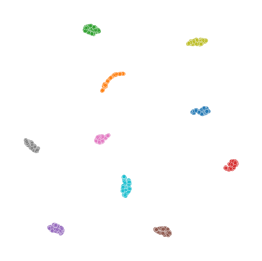

In [11]:
fig = plt.figure(figsize=(2,2), dpi=150)
sns.scatterplot(x=vis[:, 0], y=vis[:, 1], hue=metadata, s=3, alpha=0.7,
                palette='tab10', legend=False)
plt.axis('off')
plt.show()

In [7]:
from sklearn.decomposition import PCA

def pca_means(mnist_sets, n_components=16):
    n_sets, set_size, dims = mnist_sets.shape
    flat_data = mnist_sets.view(-1, dims)  # flatten sets into a single batch

    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(flat_data)  # get principal components

    pcs = pcs.reshape(n_sets, set_size, -1)  # restore set structure
    return pcs.mean(axis=1)  # mean over each set

pca_means_res = pca_means(test_sets)


In [8]:
vis = umap.fit_transform(pca_means_res)

/home/gokulg/.conda/envs/metaMI/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


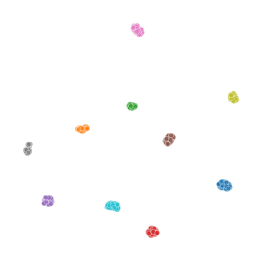

In [9]:
fig = plt.figure(figsize=(2,2), dpi=150)
sns.scatterplot(x=vis[:, 0], y=vis[:, 1], hue=metadata, s=5, alpha=0.7,
                palette='tab10', legend=False)
plt.axis('off')
plt.show()